In [ ]:
# ============================
# 0) Imports & Config
# ============================
import os
import gc
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve)
from sklearn.ensemble import RandomForestClassifier
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
df_bene = pd.read_csv('Train_Beneficiarydata.csv')
df_in = pd.read_csv('Train_Inpatientdata.csv')
df_out = pd.read_csv('Train_Outpatientdata.csv')
df_prov = pd.read_csv('Train_Label.csv')


In [ ]:
# Ensure df_prov is loaded
# Count the occurrences of each label in the 'PotentialFraud' column
fraud_counts = df_prov['PotentialFraud'].value_counts()

# Display the counts
print("Count of Fraud vs Non-Fraud Providers:")
print(fraud_counts)

Count of Fraud vs Non-Fraud Providers:
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64


In [ ]:
# ============================
# 3) BASIC SANITY + TYPES
# ============================
# Convert dates
def parse_dates(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

date_cols_in  = ["ClaimStartDt", "ClaimEndDt", "AdmissionDt", "DischargeDt"]
date_cols_out = ["ClaimStartDt", "ClaimEndDt"]
df_in  = parse_dates(df_in,  date_cols_in)
df_out = parse_dates(df_out, date_cols_out)

# Beneficiary DOB/DOD
for c in ["DOB", "DOD"]:
    if c in df_bene.columns:
        df_bene[c] = pd.to_datetime(df_bene[c], errors="coerce")

# Ensure deductible NaN -> 0 for safe sums
if "DeductibleAmtPaid" in df_in.columns:
    df_in["DeductibleAmtPaid"] = df_in["DeductibleAmtPaid"].fillna(0.0)
if "DeductibleAmtPaid" in df_out.columns:
    df_out["DeductibleAmtPaid"] = df_out["DeductibleAmtPaid"].fillna(0.0)


In [ ]:
# ============================
# 4) UNIFY CLAIMS (Inpatient + Outpatient)
# ============================
df_in["ClaimType"]  = "Inpatient"
df_out["ClaimType"] = "Outpatient"
common_cols = list(set(df_in.columns) & set(df_out.columns))
claims = pd.concat([df_in[common_cols], df_out[common_cols]], axis=0, ignore_index=True)


In [ ]:
# ============================
# 5) CLAIM-LEVEL FEATURE ENGINEERING
# ============================
import numpy as np
def build_claim_features(claims_df, bene_df, high_value_q=0.95):
    df = claims_df.copy()

    # Basic monetary
    df["TotalPaid"] = df["InscClaimAmtReimbursed"].fillna(0) + df["DeductibleAmtPaid"].fillna(0)

    # Duration: at least 1 day to avoid zeros (helps ratios)
    d = (df["ClaimEndDt"] - df["ClaimStartDt"]).dt.days
    df["ClaimDuration"] = d.fillna(0).clip(lower=0) + 1

    # Calendar features
    df["ClaimYear"]  = df["ClaimStartDt"].dt.year
    df["ClaimMonth"] = df["ClaimStartDt"].dt.month
    df["ClaimYM"]    = df["ClaimStartDt"].dt.to_period("M").astype(str)
    df["IsWeekend"]  = df["ClaimStartDt"].dt.weekday >= 5

    # Procedures / Diagnoses counts
    proc_cols = [c for c in df.columns if c.startswith("ClmProcedureCode_")]
    diag_cols = [c for c in df.columns if c.startswith("ClmDiagnosisCode_")]
    df["NumProcedures"] = df[proc_cols].notna().sum(axis=1) if proc_cols else 0
    df["NumDiagnoses"]  = df[diag_cols].notna().sum(axis=1) if diag_cols else 0

    # Join beneficiary info (demographics + chronic conditions)
    join_cols = ["BeneID", "Gender", "Race", "State", "County", "RenalDiseaseIndicator"]
    join_cols += [c for c in bene_df.columns if c.startswith("ChronicCond_")]
    join_cols = [c for c in join_cols if c in bene_df.columns]

    df = df.merge(bene_df[join_cols + ["DOB", "DOD"]], on="BeneID", how="left")

    # Age at claim
    df["AgeAtClaim"] = ((df["ClaimStartDt"] - df["DOB"]).dt.days / 365.25).astype(float)
    df["IsDeceasedAtClaim"] = (df["DOD"].notna()) & (df["DOD"] <= df["ClaimEndDt"])

    # High-value threshold (global, by quantile)
    hv_thr = df["TotalPaid"].quantile(high_value_q)
    df["IsHighValueClaim"] = df["TotalPaid"] > hv_thr
    df.attrs["high_value_threshold"] = float(hv_thr)

    # Ratio features
    df["PaidPerDay"] = df["TotalPaid"] / df["ClaimDuration"]
    df["ProcPerDay"] = df["NumProcedures"] / df["ClaimDuration"]

    # Provider-level rolling features: time gap between claims
    df = df.sort_values(["Provider", "ClaimStartDt"])
    df["PrevClaimDate"] = df.groupby("Provider")["ClaimStartDt"].shift(1)
    df["InterClaimGapDays"] = (df["ClaimStartDt"] - df["PrevClaimDate"]).dt.days
    df["InterClaimGapDays"] = df["InterClaimGapDays"].fillna(df["InterClaimGapDays"].median())

    # Diagnosis baseline: mean amount by primary diagnosis (if available)
    if "ClmDiagnosisCode_1" in df.columns:
        diag_mean = df.groupby("ClmDiagnosisCode_1")["TotalPaid"].mean().rename("Diag1_MeanPaid")
        df = df.merge(diag_mean, left_on="ClmDiagnosisCode_1", right_index=True, how="left")
        df["DiagPaidDiff"] = df["TotalPaid"] - df["Diag1_MeanPaid"].fillna(df["TotalPaid"].median())
    else:
        df["DiagPaidDiff"] = 0.0

    # Simple missing indicators
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in numeric_cols:
        if df[c].isna().any():
            df[f"{c}_missing"] = df[c].isna().astype(int)
            df[c] = df[c].fillna(df[c].median())

    # Categorical: fill missing with 'Missing'
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for c in cat_cols:
        df[c] = df[c].fillna("Missing")

    return df

claims_fe = build_claim_features(claims, df_bene)

In [ ]:
# Check the number of columns in the claims_fe DataFrame
num_claim_features = claims_fe.shape[1]

print(f"There are {num_claim_features} claim-level features in the claims_fe DataFrame.")

There are 70 claim-level features in the claims_fe DataFrame.


In [ ]:
# ============================
# 6) PROVIDER-LEVEL AGGREGATION (MAIN MODELING VIEW)
# ============================
def month_index(s):
    # Convert YYYY-MM to integer index for growth slope
    df = s.str.split("-", expand=True).astype(int)
    y = df[0]  # year
    m = df[1]  # month
    return (y - y.min()) * 12 + (m - m.min())

def aggregate_provider_features(df_claims_fe, df_bene):
    df = df_claims_fe.copy()

    # Core aggregations
    g = df.groupby("Provider")

    agg = pd.DataFrame(index=g.size().index)
    agg["Claims_Count"] = g.size()
    agg["TotalPaid_Sum"] = g["TotalPaid"].sum()
    agg["TotalPaid_Mean"] = g["TotalPaid"].mean()
    agg["TotalPaid_Median"] = g["TotalPaid"].median()
    agg["TotalPaid_Std"] = g["TotalPaid"].std().fillna(0)
    agg["TotalPaid_Max"] = g["TotalPaid"].max()
    agg["ClaimDuration_Mean"] = g["ClaimDuration"].mean()
    agg["ClaimDuration_Max"]  = g["ClaimDuration"].max()
    agg["PaidPerDay_Mean"] = g["PaidPerDay"].mean()
    agg["PaidPerDay_Std"]  = g["PaidPerDay"].std().fillna(0)
    agg["NumProcedures_Mean"] = g["NumProcedures"].mean()
    agg["NumDiagnoses_Mean"]  = g["NumDiagnoses"].mean()
    agg["UniquePatients"] = g["BeneID"].nunique()
    agg["IsWeekend_Share"] = g["IsWeekend"].mean()
    agg["HighValue_Share"] = g["IsHighValueClaim"].mean()
    agg["InterClaimGap_Mean"] = g["InterClaimGapDays"].mean()
    agg["InterClaimGap_Std"]  = g["InterClaimGapDays"].std().fillna(0)

    # Claim type distribution
    ct = df.pivot_table(index="Provider", columns="ClaimType", values="ClaimID", aggfunc="count", fill_value=0)
    for col in ["Inpatient", "Outpatient"]:
        if col not in ct.columns: ct[col] = 0
    agg["Inpatient_Share"]  = ct["Inpatient"] / (ct["Inpatient"] + ct["Outpatient"] + 1e-6)
    agg["Outpatient_Share"] = 1 - agg["Inpatient_Share"]

    # Monthly trend features (spikes, growth)
    monthly = df.groupby(["Provider", "ClaimYM"]).size().rename("Cnt").reset_index()
    # variance of monthly counts & max jump
    mm = monthly.groupby("Provider")["Cnt"].agg(["mean","std","max"])
    agg["MonthlyCnt_Std"] = mm["std"].fillna(0)
    # Growth slope via simple linear fit on month index
    by_p = []
    for p, sub in monthly.groupby("Provider"):
        x = month_index(sub["ClaimYM"])
        if len(x) >= 2:
            slope = np.polyfit(x, sub["Cnt"].values, 1)[0]
        else:
            slope = 0.0
        by_p.append((p, slope))
    growth_df = pd.DataFrame(by_p, columns=["Provider", "MonthlyCnt_Slope"]).set_index("Provider")
    agg = agg.join(growth_df, how="left").fillna({"MonthlyCnt_Slope": 0.0})

    # Diversity features: unique diag/proc codes across all claim columns
    diag_cols = [c for c in df.columns if c.startswith("ClmDiagnosisCode_")]
    proc_cols = [c for c in df.columns if c.startswith("ClmProcedureCode_")]

    def nunique_flat(group, cols):
        # flatten values across columns for the provider, count unique (excluding 'Missing')
        vals = pd.unique(pd.concat([group[c].astype(str) for c in cols if c in group], axis=0))
        vals = vals[vals != "Missing"]
        return len(vals)

    diag_div = df.groupby("Provider").apply(lambda g: nunique_flat(g, diag_cols)).rename("DiagCodes_Unique")
    proc_div = df.groupby("Provider").apply(lambda g: nunique_flat(g, proc_cols)).rename("ProcCodes_Unique")
    agg = agg.join(diag_div).join(proc_div)

    # Patient mix (from chronic conditions): average across claims (proxy)
    chronic_cols = [c for c in df.columns if c.startswith("ChronicCond_")]
    for c in chronic_cols:
        df[c] = df[c].map({1: 1, 2: 0})
        agg[f"{c}_Rate"] = g[c].mean()

    # Demographics mix (Gender, Race, State, Renal)
    # - Gender: share male coded as 1/2 in your data; convert to binary indicators
    if "Gender" in df.columns:
        agg["Share_Male"] = g["Gender"].apply(lambda s: (s==2).mean() if hasattr(s, "mean") else 0)

    if "Race" in df.columns:
        # Fraction of each race code 1..5
        for r in sorted(df["Race"].dropna().unique()):
            agg[f"Race_{r}_Share"] = g["Race"].apply(lambda s, r=r: (s==r).mean())

    if "RenalDiseaseIndicator" in df.columns:
        agg["Renal_Y_Share"] = g["RenalDiseaseIndicator"].apply(lambda s: (s.astype(str)=="Y").mean())

    # Risk ratio vs state mean (Provider mean / State mean)
    if "State" in df.columns:
        state_mean = df.groupby("State")["TotalPaid"].mean().rename("StateMeanPaid")
        tmp = df[["Provider","State","TotalPaid"]].merge(state_mean, on="State", how="left")
        tmp["Paid_vs_State"] = tmp["TotalPaid"] / (tmp["StateMeanPaid"] + 1e-6)
        agg["Paid_vs_State_Mean"] = tmp.groupby("Provider")["Paid_vs_State"].mean()

    agg.reset_index(inplace=True)
    return agg

provider_features = aggregate_provider_features(claims_fe, df_bene)

/tmp/ipython-input-801632365.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diag_div = df.groupby("Provider").apply(lambda g: nunique_flat(g, diag_cols)).rename("DiagCodes_Unique")
/tmp/ipython-input-801632365.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  proc_div = df.groupby("Provider").apply(lambda g: nunique_flat(g, proc_cols)).rename("ProcCodes_Unique")


In [ ]:
# Check the number of columns in the provider_features DataFrame
num_provider_features = provider_features.shape[1]

print(f"There are {num_provider_features} provider-level features in the provider_features DataFrame.")

There are 42 provider-level features in the provider_features DataFrame.


In [ ]:
provider_features

,Provider,Claims_Count,TotalPaid_Sum,TotalPaid_Mean,TotalPaid_Median,TotalPaid_Std,TotalPaid_Max,ClaimDuration_Mean,ClaimDuration_Max,PaidPerDay_Mean,...,ChronicCond_Osteoporasis_Rate,ChronicCond_rheumatoidarthritis_Rate,ChronicCond_stroke_Rate,Share_Male,Race_1_Share,Race_2_Share,Race_3_Share,Race_5_Share,Renal_Y_Share,Paid_vs_State_Mean
0,PRV51001,25,109980.0,4399.200000,400.0,11113.779555,43068.0,2.440000,15,1061.072000,...,0.240000,0.320000,0.240000,0.640000,0.840000,0.160000,0.000000,0.000000,0.320000,3.957805
1,PRV51003,132,671956.0,5090.575758,1750.0,7643.198026,58068.0,4.674242,28,1298.615410,...,0.250000,0.287879,0.090909,0.590909,0.810606,0.181818,0.000000,0.007576,0.219697,4.577848
2,PRV51004,149,52480.0,352.214765,70.0,689.593344,3300.0,2.429530,21,250.363050,...,0.328859,0.308725,0.114094,0.691275,0.805369,0.161074,0.033557,0.000000,0.154362,0.345853
3,PRV51005,1165,284610.0,244.300429,70.0,491.462817,4080.0,2.088412,21,196.533055,...,0.295279,0.284120,0.106438,0.561373,0.766524,0.224893,0.008584,0.000000,0.222318,0.219739
4,PRV51007,72,36974.0,513.527778,80.0,1621.897671,11068.0,1.958333,21,243.681944,...,0.291667,0.305556,0.166667,0.527778,0.805556,0.194444,0.000000,0.000000,0.152778,0.461245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,10770.0,384.642857,75.0,822.230400,3300.0,3.142857,21,200.629252,...,0.464286,0.321429,0.142857,0.428571,0.785714,0.071429,0.000000,0.142857,0.178571,0.335038
5406,PRV57760,22,4770.0,216.818182,85.0,309.998254,1100.0,1.318182,8,216.022727,...,0.500000,0.045455,0.000000,0.227273,0.818182,0.181818,0.000000,0.000000,0.000000,0.188856
5407,PRV57761,82,18840.0,229.756098,80.0,416.386500,2200.0,2.390244,21,157.134674,...,0.390244,0.292683,0.121951,0.512195,0.853659,0.085366,0.012195,0.048780,0.280488,0.200404
5408,PRV57762,1,1900.0,1900.000000,1900.0,0.000000,1900.0,1.000000,1,1900.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.695417


In [ ]:
provider_features.columns

Index(['Provider', 'Claims_Count', 'TotalPaid_Sum', 'TotalPaid_Mean',
       'TotalPaid_Median', 'TotalPaid_Std', 'TotalPaid_Max',
       'ClaimDuration_Mean', 'ClaimDuration_Max', 'PaidPerDay_Mean',
       'PaidPerDay_Std', 'NumProcedures_Mean', 'NumDiagnoses_Mean',
       'UniquePatients', 'IsWeekend_Share', 'HighValue_Share',
       'InterClaimGap_Mean', 'InterClaimGap_Std', 'Inpatient_Share',
       'Outpatient_Share', 'MonthlyCnt_Std', 'MonthlyCnt_Slope',
       'DiagCodes_Unique', 'ProcCodes_Unique', 'ChronicCond_Alzheimer_Rate',
       'ChronicCond_Heartfailure_Rate', 'ChronicCond_KidneyDisease_Rate',
       'ChronicCond_Cancer_Rate', 'ChronicCond_ObstrPulmonary_Rate',
       'ChronicCond_Depression_Rate', 'ChronicCond_Diabetes_Rate',
       'ChronicCond_IschemicHeart_Rate', 'ChronicCond_Osteoporasis_Rate',
       'ChronicCond_rheumatoidarthritis_Rate', 'ChronicCond_stroke_Rate',
       'Share_Male', 'Race_1_Share', 'Race_2_Share', 'Race_3_Share',
       'Race_5_Share', 'Renal_Y

In [ ]:
# ============================
# 7) TARGET MERGE & SPLIT
# ============================
df_prov["PotentialFraud"] = df_prov["PotentialFraud"].map({"Yes":1, "No":0})
data = provider_features.merge(df_prov, on="Provider", how="left")

# Keep only providers present in label table
data = data[~data["PotentialFraud"].isna()].copy()
data["PotentialFraud"] = data["PotentialFraud"].astype(int)

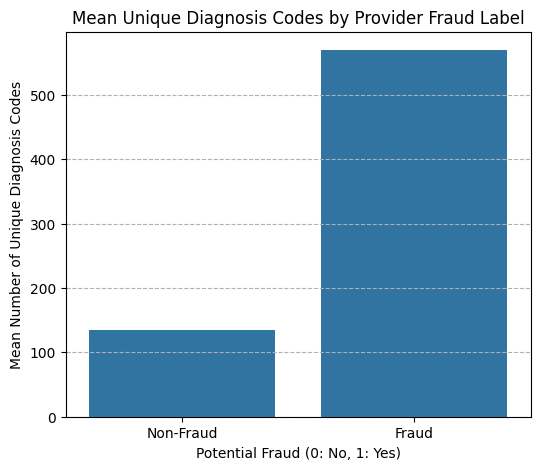

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean DiagCodes_Unique for each fraud category
mean_diag_codes_unique = data.groupby('PotentialFraud')['DiagCodes_Unique'].mean().reset_index()

plt.figure(figsize=(6, 5))
sns.barplot(x='PotentialFraud', y='DiagCodes_Unique', data=mean_diag_codes_unique)
plt.title('Mean Unique Diagnosis Codes by Provider Fraud Label')
plt.xlabel('Potential Fraud (0: No, 1: Yes)')
plt.ylabel('Mean Number of Unique Diagnosis Codes')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud']) # Set custom x-axis labels
plt.grid(axis='y', linestyle='--')

# Save the plot (optional)
plt.savefig(FIG_DIR/"bi_barplot_diag_codes_unique_fraud.png", dpi=150)

# Display the plot
plt.show()

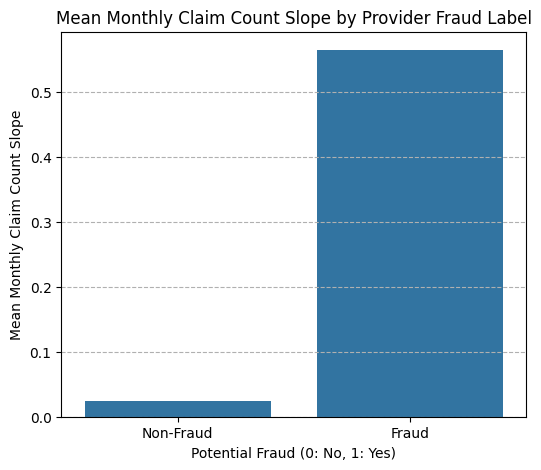

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean MonthlyCnt_Slope for each fraud category
mean_monthly_cnt_slope = data.groupby('PotentialFraud')['MonthlyCnt_Slope'].mean().reset_index()

plt.figure(figsize=(6, 5))
sns.barplot(x='PotentialFraud', y='MonthlyCnt_Slope', data=mean_monthly_cnt_slope)
plt.title('Mean Monthly Claim Count Slope by Provider Fraud Label')
plt.xlabel('Potential Fraud (0: No, 1: Yes)')
plt.ylabel('Mean Monthly Claim Count Slope')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud']) # Set custom x-axis labels
plt.grid(axis='y', linestyle='--')

# Save the plot (optional)
plt.savefig(FIG_DIR/"bi_barplot_monthly_cnt_slope_fraud.png", dpi=150)

# Display the plot
plt.show()

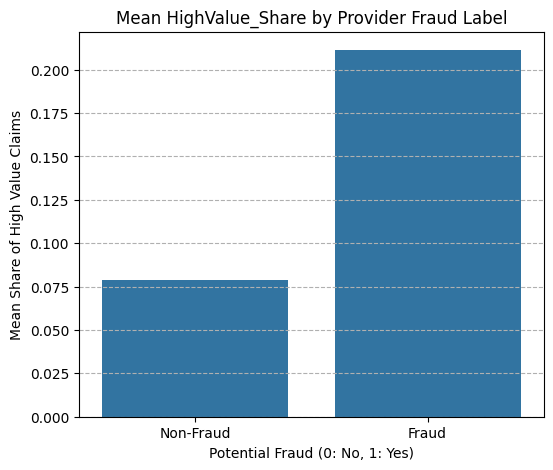

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean HighValue_Share for each fraud category
mean_high_value_share = data.groupby('PotentialFraud')['HighValue_Share'].mean().reset_index()

plt.figure(figsize=(6, 5))
sns.barplot(x='PotentialFraud', y='HighValue_Share', data=mean_high_value_share)
plt.title('Mean HighValue_Share by Provider Fraud Label')
plt.xlabel('Potential Fraud (0: No, 1: Yes)')
plt.ylabel('Mean Share of High Value Claims')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud']) # Set custom x-axis labels
plt.grid(axis='y', linestyle='--')

# Save the plot (optional)
plt.savefig(FIG_DIR/"bi_barplot_mean_highvalue_share_fraud.png", dpi=150)

# Display the plot
plt.show()

In [ ]:
# ============================
# 8) — E D A —
# ============================

# --- Univariate ---
import matplotlib.pyplot as plt
from pathlib import Path
FIG_DIR = Path("figs")
FIG_DIR.mkdir(exist_ok=True)
def eda_univariate(df_claims_fe, df_provider):
    # Distribution of claim amounts (and log)
    plt.figure(); df_claims_fe["TotalPaid"].hist(bins=100); plt.title("TotalPaid distribution"); plt.xlabel("TotalPaid"); plt.ylabel("Count")
    plt.savefig(FIG_DIR/"uni_totalpaid_hist.png", dpi=150); plt.close()

    plt.figure(); np.log1p(df_claims_fe["TotalPaid"]).hist(bins=100); plt.title("log(1+TotalPaid) distribution"); plt.xlabel("log1p(TotalPaid)")
    plt.savefig(FIG_DIR/"uni_totalpaid_log_hist.png", dpi=150); plt.close()

    # Claim duration
    plt.figure(); df_claims_fe["ClaimDuration"].hist(bins=60); plt.title("ClaimDuration distribution"); plt.xlabel("Days")
    plt.savefig(FIG_DIR/"uni_duration_hist.png", dpi=150); plt.close()

    # Number of claims per provider
    plt.figure(); df_provider["Claims_Count"].hist(bins=100); plt.title("#Claims per Provider (long tail)"); plt.xlabel("#Claims")
    plt.yscale("log"); plt.savefig(FIG_DIR/"uni_claims_per_provider_hist.png", dpi=150); plt.close()

    # Fraud vs non-fraud ratio
    fraud_ratio = df_provider.merge(df_prov, on="Provider", how="left")["PotentialFraud"].mean()
    with open(FIG_DIR/"class_balance.txt","w") as f:
        f.write(f"Fraud rate (providers): {fraud_ratio:.4f}\n")

eda_univariate(claims_fe, provider_features)


In [ ]:
# --- Bivariate ---
import matplotlib.pyplot as plt
def eda_bivariate(df_claims_fe, data_provider):
    # Boxplot TotalPaid vs Fraud (provider label mapped to claims)
    lbl = df_claims_fe.merge(df_prov[["Provider","PotentialFraud"]], on="Provider", how="left")
    # Downsample for speed
    lbl_small = lbl.sample(min(80000, len(lbl)), random_state=RANDOM_STATE)

    plt.figure()
    # use plain matplotlib boxplot
    g0 = lbl_small[lbl_small["PotentialFraud"]==0]["TotalPaid"].values
    g1 = lbl_small[lbl_small["PotentialFraud"]==1]["TotalPaid"].values
    plt.boxplot([g0, g1], labels=["Non-Fraud","Fraud"], showfliers=False)
    plt.title("TotalPaid by Fraud label (claim-level, provider label)")
    plt.ylabel("TotalPaid")
    plt.savefig(FIG_DIR/"bi_box_totalpaid_fraud.png", dpi=150); plt.close()

    # Average claim amount between fraud & non-fraud providers
    tmp = data_provider.merge(df_prov, on="Provider", how="left")
    means = tmp.groupby("PotentialFraud")["TotalPaid_Mean"].mean()
    means.to_csv(FIG_DIR/"bi_avg_paid_by_fraud.csv")

    # Fraud rate vs #claims per provider
    tmp["Claims_Bin"] = pd.qcut(tmp["Claims_Count"], q=10, duplicates="drop")
    fr_by_bin = tmp.groupby("Claims_Bin")["PotentialFraud"].mean()
    fr_by_bin.to_csv(FIG_DIR/"bi_fraud_rate_vs_claimcount_bins.csv")

    # Fraud rates by region (State) – requires State via claims+beneficiary merge
    by_state = lbl.groupby("State")["PotentialFraud"].mean().dropna().sort_values(ascending=False)[:30]
    plt.figure()
    by_state.plot(kind="bar")
    plt.title("Fraud rate by State (top 30 shown)")
    plt.tight_layout()
    plt.savefig(FIG_DIR/"bi_fraud_rate_by_state.png", dpi=150); plt.close()

eda_bivariate(claims_fe, provider_features)

/tmp/ipython-input-3555189353.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["Non-Fraud","Fraud"], showfliers=False)
/tmp/ipython-input-3555189353.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fr_by_bin = tmp.groupby("Claims_Bin")["PotentialFraud"].mean()


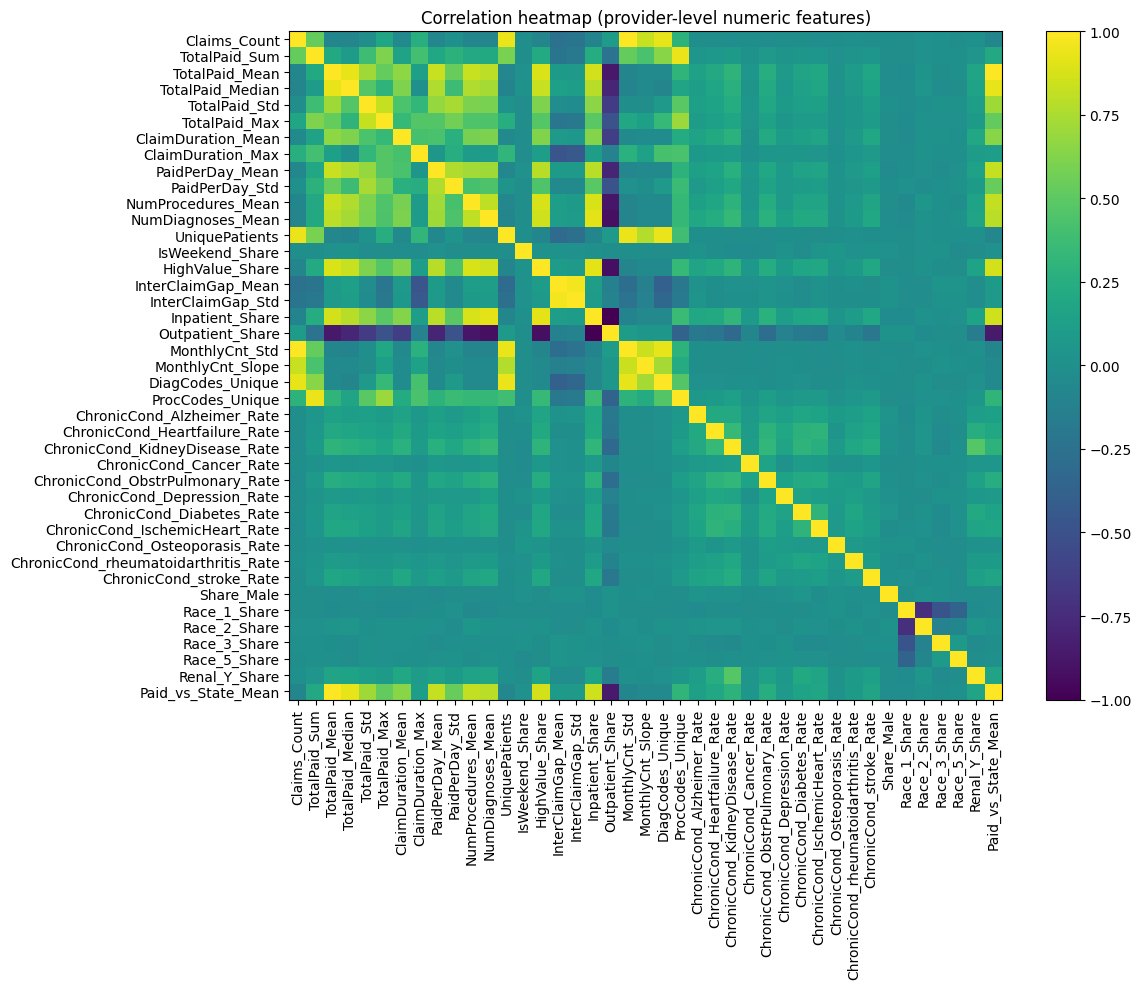

In [ ]:
# --- Multivariate ---
def eda_multivariate(df_provider):
    # Correlation heatmap (numeric provider features)
    num_cols = df_provider.select_dtypes(include=[np.number]).columns.tolist()
    corr = df_provider[num_cols].corr()
    plt.figure(figsize=(12,10)) # Increased figure size for better readability
    plt.imshow(corr, aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.title("Correlation heatmap (provider-level numeric features)")

    # Add ticks and labels
    plt.xticks(range(len(num_cols)), num_cols, rotation=90) # Add x-axis labels and rotate
    plt.yticks(range(len(num_cols)), num_cols) # Add y-axis labels

    plt.tight_layout()
    plt.savefig(FIG_DIR/"multi_corr_heatmap.png", dpi=150)
    plt.show() # Display the plot in the notebook
    plt.close()


    # PCA & t-SNE on claim-level with provider labels (downsampled)
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    cols_for_embed = ["TotalPaid","ClaimDuration","PaidPerDay","NumProcedures","NumDiagnoses","InterClaimGapDays"]
    emb = claims_fe.merge(df_prov[["Provider","PotentialFraud"]], on="Provider", how="left")
    emb = emb.dropna(subset=["PotentialFraud"])
    emb_small = emb.sample(min(30000, len(emb)), random_state=RANDOM_STATE).copy()
    X = emb_small[cols_for_embed].fillna(0).values
    y = emb_small["PotentialFraud"].values

    # Scale for TSNE distance stability
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
    plt.figure(); plt.scatter(pca2[:,0], pca2[:,1], s=3, c=y, alpha=0.5)
    plt.title("PCA (claims) colored by provider fraud label")
    plt.savefig(FIG_DIR/"multi_pca_claims.png", dpi=150); plt.close()

    tsne2 = TSNE(n_components=2, random_state=RANDOM_STATE, init="pca", learning_rate="auto").fit_transform(Xs)
    plt.figure(); plt.scatter(tsne2[:,0], tsne2[:,1], s=3, c=y, alpha=0.5)
    plt.title("t-SNE (claims) colored by provider fraud label")
    plt.savefig(FIG_DIR/"multi_tsne_claims.png", dpi=150); plt.close()

    # t-SNE on provider-level features
    X_prov = df_provider.select_dtypes(include=[np.number]).drop(columns=["PotentialFraud"], errors='ignore').values
    y_prov = data["PotentialFraud"].values # Use 'data' which has the merged label

    scaler_prov = StandardScaler()
    Xs_prov = scaler_prov.fit_transform(X_prov)

    tsne_prov = TSNE(n_components=2, random_state=RANDOM_STATE, init="pca", learning_rate="auto").fit_transform(Xs_prov)
    plt.figure(); plt.scatter(tsne_prov[:,0], tsne_prov[:,1], s=10, c=y_prov, alpha=0.5)
    plt.title("t-SNE (providers) colored by fraud label")
    plt.savefig(FIG_DIR/"multi_tsne_providers.png", dpi=150); plt.close()


eda_multivariate(provider_features)

In [ ]:
# Read the CSV file
fraud_rate_by_claim_count = pd.read_csv(FIG_DIR/"bi_fraud_rate_vs_claimcount_bins.csv")

# Display the data
display(fraud_rate_by_claim_count)

,Claims_Bin,PotentialFraud
0,"(0.999, 3.0]",0.006745
1,"(3.0, 7.0]",0.009398
2,"(7.0, 13.0]",0.018587
3,"(13.0, 21.0]",0.046763
4,"(21.0, 31.0]",0.041176
5,"(31.0, 46.0]",0.063462
6,"(46.0, 70.0]",0.077758
7,"(70.0, 115.0]",0.122180
8,"(115.0, 228.0]",0.173507
9,"(228.0, 8240.0]",0.381481


In [ ]:

# --- Time-based ---
def eda_time_based(df_claims_fe):
    # Trend of claims per month split by fraud/non-fraud
    cl = df_claims_fe.merge(df_prov[["Provider","PotentialFraud"]], on="Provider", how="left")
    trend = cl.groupby(["ClaimYM","PotentialFraud"]).size().unstack(fill_value=0)
    trend.index = pd.PeriodIndex(trend.index, freq="M").to_timestamp()
    trend.sort_index(inplace=True)

    plt.figure()
    if 0 in trend: plt.plot(trend.index, trend[0], label="Non-Fraud")
    if 1 in trend: plt.plot(trend.index, trend[1], label="Fraud")
    plt.legend(); plt.title("Monthly claims trend by provider label"); plt.ylabel("#Claims")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(FIG_DIR/"time_trend_claims.png", dpi=150); plt.close()

    # Sudden spikes: z-score of monthly counts per provider
    mcnt = cl.groupby(["Provider","ClaimYM"]).size().rename("Cnt").reset_index()
    def spike_score(x):
        return ((x - x.mean()) / (x.std() + 1e-6)).max()
    spikes = mcnt.groupby("Provider")["Cnt"].apply(spike_score).rename("MonthlyCnt_MaxZ")
    spikes.sort_values(ascending=False).head(50).to_csv(FIG_DIR/"time_spikes_top50.csv")

eda_time_based(claims_fe)


In [ ]:

# ============================
# 9) MODEL DATA (X, y) + PREPROCESSING
# ============================
# We will use tree models (no scaling needed), but we’ll keep an optional scaler for non-tree baselines.
label_df = df_prov[["Provider","PotentialFraud"]]
model_df = provider_features.merge(label_df, on="Provider", how="inner").copy()
model_df.to_csv("model_df.csv", index=False)
# Drop leakage/non-features
drop_cols = ["Provider"]
y = model_df["PotentialFraud"].astype(int)
X = model_df.drop(columns=drop_cols + ["PotentialFraud"])

# Fill any remaining NaNs (should be few after our FE)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)



In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data[data['PotentialFraud'] == 0]
df_minority = data[data['PotentialFraud'] == 1]

# Downsample majority class to match minority class size (506)
df_majority_downsampled = resample(df_majority,
                                   replace=False,     # without replacement
                                   n_samples=len(df_minority), # 506
                                   random_state=RANDOM_STATE)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [ ]:
# Features and target
X_bal = df_balanced.drop(columns=['Provider','PotentialFraud'])
y_bal = df_balanced['PotentialFraud']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_bal, y_bal, test_size=0.25, stratify=y_bal, random_state=RANDOM_STATE
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_bal = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    class_weight=None  # no need for class_weight now, since data is balanced
)

rf_bal.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
import pickle
import joblib
import os

# Save model
with open("rf_bal.pkl", "wb") as f:
    pickle.dump(rf_bal, f)

# Create the directory if it doesn't exist
os.makedirs("rf_bal", exist_ok=True)

feature_columns = list(X_train.columns)
joblib.dump(feature_columns, "rf_bal/provider_features.pkl")

['rf_bal/provider_features.pkl']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

y_pred_bal = rf_bal.predict(X_val)
proba_val_bal = rf_bal.predict_proba(X_val)[:, 1]

# Calculate overall accuracy
accuracy = accuracy_score(y_val, y_pred_bal)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_val, proba_val_bal)

# Generate classification report
report = classification_report(y_val, y_pred_bal)

print("\nClassification Report:")
print(report)


print("Overall Accuracy: ",accuracy)
print("ROC AUC: ", roc_auc)


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       127
           1       0.89      0.87      0.88       126

    accuracy                           0.89       253
   macro avg       0.89      0.89      0.89       253
weighted avg       0.89      0.89      0.89       253

Overall Accuracy:  0.8853754940711462
ROC AUC:  0.9475065616797901


In [ ]:
%pip install xgboost

In [ ]:
from xgboost import XGBClassifier

xgb_bal = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')

xgb_bal.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:11:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb = xgb_bal.predict(X_val)
proba_val_xgb = xgb_bal.predict_proba(X_val)[:, 1]

accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val, proba_val_xgb)
report_xgb = classification_report(y_val, y_pred_xgb)

print("\nXGBoost Classification Report:")
print(report_xgb)
print("XGBoost Overall Accuracy: ", accuracy_xgb)
print("XGBoost ROC AUC: ", roc_auc_xgb)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       127
           1       0.91      0.85      0.88       126

    accuracy                           0.89       253
   macro avg       0.89      0.89      0.89       253
weighted avg       0.89      0.89      0.89       253

XGBoost Overall Accuracy:  0.8853754940711462
XGBoost ROC AUC:  0.9336957880264967


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Initialize and train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions on the validation data
y_pred_gnb = gnb.predict(X_val)
proba_val_gnb = gnb.predict_proba(X_val)[:, 1]

# Evaluate the model
accuracy_gnb = accuracy_score(y_val, y_pred_gnb)
roc_auc_gnb = roc_auc_score(y_val, proba_val_gnb)
report_gnb = classification_report(y_val, y_pred_gnb)

print("\nGaussian Naive Bayes Classification Report:")
print(report_gnb)
print("Gaussian Naive Bayes Overall Accuracy: ", accuracy_gnb)
print("Gaussian Naive Bayes ROC AUC: ", roc_auc_gnb)


Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       127
           1       0.90      0.67      0.77       126

    accuracy                           0.80       253
   macro avg       0.82      0.80      0.79       253
weighted avg       0.82      0.80      0.79       253

Gaussian Naive Bayes Overall Accuracy:  0.7984189723320159
Gaussian Naive Bayes ROC AUC:  0.93275840519935


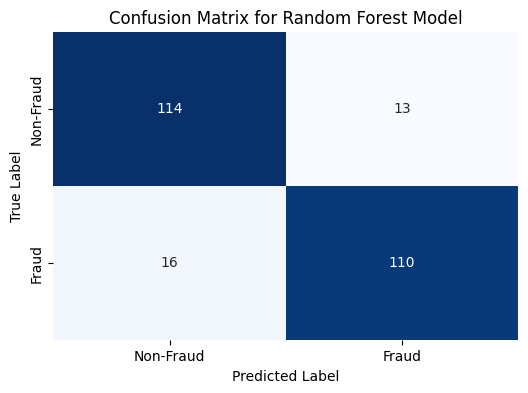

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred_bal)

# Display the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

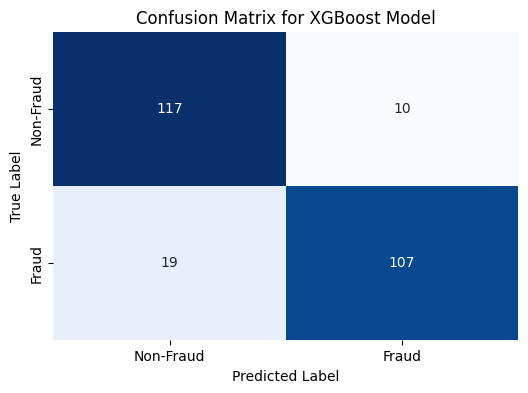

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_val, y_pred_xgb)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

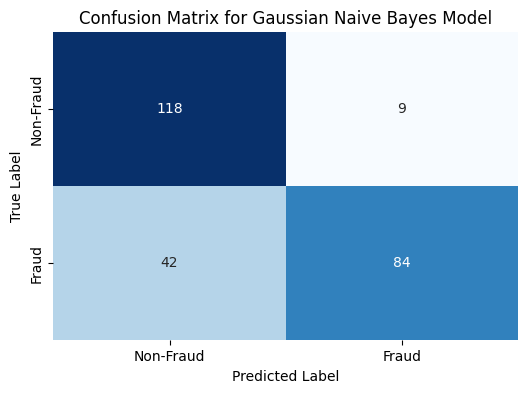

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix for Gaussian Naive Bayes
cm_gnb = confusion_matrix(y_val, y_pred_gnb)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Gaussian Naive Bayes Model')
plt.show()


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       127
           1       0.89      0.87      0.88       126

    accuracy                           0.89       253
   macro avg       0.89      0.89      0.89       253
weighted avg       0.89      0.89      0.89       253

Gradient Boosting Overall Accuracy:  0.8853754940711462
Gradient Boosting ROC AUC:  0.9478815148106486


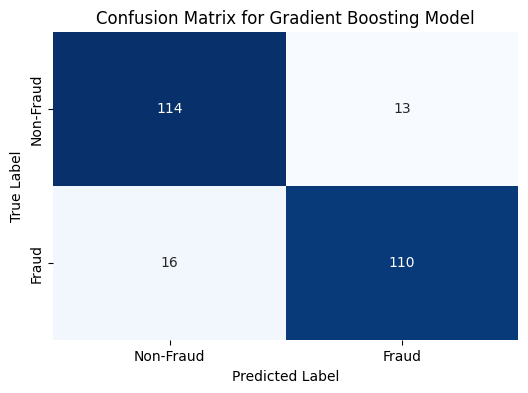

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb.fit(X_train, y_train)

# Make predictions on the validation data
y_pred_gb = gb.predict(X_val)
proba_val_gb = gb.predict_proba(X_val)[:, 1]

# Evaluate the model
accuracy_gb = accuracy_score(y_val, y_pred_gb)
roc_auc_gb = roc_auc_score(y_val, proba_val_gb)
report_gb = classification_report(y_val, y_pred_gb)
cm_gb = confusion_matrix(y_val, y_pred_gb)


print("\nGradient Boosting Classification Report:")
print(report_gb)
print("Gradient Boosting Overall Accuracy: ", accuracy_gb)
print("Gradient Boosting ROC AUC: ", roc_auc_gb)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Gradient Boosting Model')
plt.show()

In [ ]:
%pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.2 MB/s eta 0:00:00


In [ ]:
# Load model_df.csv
model_df = pd.read_csv("model_df.csv")
display(model_df.head())

,Provider,Claims_Count,TotalPaid_Sum,TotalPaid_Mean,TotalPaid_Median,TotalPaid_Std,TotalPaid_Max,ClaimDuration_Mean,ClaimDuration_Max,PaidPerDay_Mean,...,ChronicCond_rheumatoidarthritis_Rate,ChronicCond_stroke_Rate,Share_Male,Race_1_Share,Race_2_Share,Race_3_Share,Race_5_Share,Renal_Y_Share,Paid_vs_State_Mean,PotentialFraud
0,PRV51001,25,109980.0,4399.200000,400.0,11113.779555,43068.0,2.440000,15,1061.072000,...,0.320000,0.240000,0.640000,0.840000,0.160000,0.000000,0.000000,0.320000,3.957805,0
1,PRV51003,132,671956.0,5090.575758,1750.0,7643.198026,58068.0,4.674242,28,1298.615410,...,0.287879,0.090909,0.590909,0.810606,0.181818,0.000000,0.007576,0.219697,4.577848,1
2,PRV51004,149,52480.0,352.214765,70.0,689.593344,3300.0,2.429530,21,250.363050,...,0.308725,0.114094,0.691275,0.805369,0.161074,0.033557,0.000000,0.154362,0.345853,0
3,PRV51005,1165,284610.0,244.300429,70.0,491.462817,4080.0,2.088412,21,196.533055,...,0.284120,0.106438,0.561373,0.766524,0.224893,0.008584,0.000000,0.222318,0.219739,1
4,PRV51007,72,36974.0,513.527778,80.0,1621.897671,11068.0,1.958333,21,243.681944,...,0.305556,0.166667,0.527778,0.805556,0.194444,0.000000,0.000000,0.152778,0.461245,0


In [ ]:
# Filter for non-fraudulent providers
non_fraud_df = model_df[model_df['PotentialFraud'] == 0].copy()
display(non_fraud_df.head())

,Provider,Claims_Count,TotalPaid_Sum,TotalPaid_Mean,TotalPaid_Median,TotalPaid_Std,TotalPaid_Max,ClaimDuration_Mean,ClaimDuration_Max,PaidPerDay_Mean,...,ChronicCond_rheumatoidarthritis_Rate,ChronicCond_stroke_Rate,Share_Male,Race_1_Share,Race_2_Share,Race_3_Share,Race_5_Share,Renal_Y_Share,Paid_vs_State_Mean,PotentialFraud
0,PRV51001,25,109980.0,4399.200000,400.0,11113.779555,43068.0,2.440000,15,1061.072000,...,0.320000,0.240000,0.640000,0.840000,0.160000,0.000000,0.0,0.320000,3.957805,0
2,PRV51004,149,52480.0,352.214765,70.0,689.593344,3300.0,2.429530,21,250.363050,...,0.308725,0.114094,0.691275,0.805369,0.161074,0.033557,0.0,0.154362,0.345853,0
4,PRV51007,72,36974.0,513.527778,80.0,1621.897671,11068.0,1.958333,21,243.681944,...,0.305556,0.166667,0.527778,0.805556,0.194444,0.000000,0.0,0.152778,0.461245,0
5,PRV51008,43,37946.0,882.465116,90.0,3410.926165,22068.0,2.534884,21,314.186047,...,0.139535,0.046512,0.558140,0.790698,0.209302,0.000000,0.0,0.232558,0.795177,0
6,PRV51011,58,17998.0,310.310345,80.0,829.554503,6068.0,1.551724,18,198.222222,...,0.275862,0.034483,0.534483,0.879310,0.120690,0.000000,0.0,0.206897,0.279175,0


In [ ]:
# Calculate percentile thresholds based on non-fraudulent data
non_fraud_thresholds = {}
numeric_cols = non_fraud_df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude the target variable 'PotentialFraud' from threshold calculation
if 'PotentialFraud' in numeric_cols:
    numeric_cols.remove('PotentialFraud')

for col in numeric_cols:
    # Calculate percentiles (e.g., 75th, 90th, 95th)
    q75 = non_fraud_df[col].quantile(0.75)
    q90 = non_fraud_df[col].quantile(0.90)
    q95 = non_fraud_df[col].quantile(0.95)
    non_fraud_thresholds[col] = {"high": q75, "very high": q90, "unusually high": q95}

print("Calculated thresholds based on non-fraudulent data:")
for col, thresholds in non_fraud_thresholds.items():
    print(f"  {col}: {thresholds}")

Calculated thresholds based on non-fraudulent data:
  Claims_Count: {'high': np.float64(72.0), 'very high': np.float64(172.69999999999982), 'unusually high': np.float64(284.0)}
  TotalPaid_Sum: {'high': np.float64(60204.0), 'very high': np.float64(153421.59999999986), 'unusually high': np.float64(238781.79999999987)}
  TotalPaid_Mean: {'high': np.float64(1107.6724137931035), 'very high': np.float64(4980.32805429863), 'unusually high': np.float64(9068.0)}
  TotalPaid_Median: {'high': np.float64(100.0), 'very high': np.float64(1700.0), 'unusually high': np.float64(7068.0)}
  TotalPaid_Std: {'high': np.float64(2602.0780214738006), 'very high': np.float64(6194.427394334794), 'unusually high': np.float64(8737.270137706755)}
  TotalPaid_Max: {'high': np.float64(13068.0), 'very high': np.float64(33068.0), 'unusually high': np.float64(46068.0)}
  ClaimDuration_Mean: {'high': np.float64(3.3837752053771473), 'very high': np.float64(5.0), 'unusually high': np.float64(6.448299319727889)}
  ClaimDu

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -------------------------------
# 1. Initialize SHAP Explainer
# -------------------------------
explainer = shap.TreeExplainer(rf_bal)

# -------------------------------
# 2. Compute SHAP values for X_val
# -------------------------------
shap_values = explainer.shap_values(X_val)

# Handle binary classification (Fraud = 1)
if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1]  # Positive class
    base_value = explainer.expected_value[1]
else:
    shap_values_to_use = shap_values[:, :, 1]  # If single array with class dimension
    base_value = explainer.expected_value[1]

# Debug
print("SHAP values shape:", shap_values_to_use.shape)
print("X_val shape:", X_val.shape)

# -------------------------------
# 3. Global Explanations
# -------------------------------
print("\nGenerating global SHAP plots...")

plt.title("SHAP Summary Plot (Feature Impact on Fraud)")
shap.summary_plot(shap_values_to_use, X_val, feature_names=X_val.columns)
plt.show()

plt.title("SHAP Bar Plot (Mean Absolute SHAP Value)")
shap.summary_plot(shap_values_to_use, X_val, plot_type="bar", feature_names=X_val.columns)
plt.show()

# -------------------------------
# 4. Local Explanations for Each Claim
# -------------------------------
print("\nGenerating local explanation report...")

# Get model predictions (probability of fraud)
fraud_prob = rf_bal.predict_proba(X_val)[:, 1]

# Create a DataFrame to store local explanations
local_explanations = []

for i in range(X_val.shape[0]):
    shap_row = shap_values_to_use[i, :]
    feature_row = X_val.iloc[i, :]

    # Sort features by absolute SHAP value (most impactful first)
    sorted_idx = np.argsort(np.abs(shap_row))[::-1]
    top_features = [(X_val.columns[j], shap_row[j], feature_row[j]) for j in sorted_idx[:5]]

    explanation_text = "; ".join([
        f"{name}={value:.3f} (impact={impact:.3f})"
        for name, impact, value in top_features
    ])

    local_explanations.append({
        "Index": i,
        "Fraud_Probability": fraud_prob[i],
        "Predicted_Label": int(fraud_prob[i] >= 0.5),
        "Top_Feature_Impacts": explanation_text
    })

# Convert to DataFrame
report_df = pd.DataFrame(local_explanations)

# Save to CSV
report_filename = "fraud_shap_explanation_report.csv"
report_df.to_csv(report_filename, index=False)
print(f"\nLocal explanation report saved as: {report_filename}")

# -------------------------------
# 5. Optional: Visualize a Single Sample Force Plot
# -------------------------------
sample_index = 0  # change if needed
print(f"\nForce plot for sample index {sample_index}:")

sample_shap_values = shap_values_to_use[sample_index, :]
sample_features = X_val.iloc[sample_index, :]

shap.plots.force(
    base_value,
    sample_shap_values,
    sample_features,
    matplotlib=True,
    feature_names=X_val.columns
)
plt.show()


In [ ]:
import shap
import pandas as pd
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
import numpy as np
import os
from reportlab.lib.enums import TA_LEFT # Import for alignment

# ===========================
# 1. PDF Report Generator
# ===========================
def generate_fraud_pdf_report(fraud_report, filename="fraud_explanation_report.pdf"):
    doc = SimpleDocTemplate(filename, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    # Use a style that allows word wrapping
    normal_style = styles['Normal']
    normal_style.wordWrap = 'CJK' # Or 'True' for non-CJK languages, but CJK is safer

    # --- Report Header ---
    story.append(Paragraph("<b>Fraud Detection Model: Provider-Level Explanation Report</b>", styles['h1']))
    story.append(Spacer(1, 12))

    # --- Summary ---
    story.append(Paragraph("<b>1. Report Overview</b>", styles['h2']))
    story.append(Spacer(1, 6))
    story.append(Paragraph(
        f"This report summarizes the fraud risk detected for <b>{len(fraud_report)}</b> providers "
        "based on model predictions and SHAP explanations. Only providers flagged as potential fraud are included.",
        normal_style # Use word-wrapping style here too
    ))
    story.append(Spacer(1, 12))

    # --- Provider-wise Explanation Table ---
    story.append(Paragraph("<b>2. Provider-Level Fraud Explanation</b>", styles['h2']))
    story.append(Spacer(1, 6))

    data = [["Provider ID", "Fraud Probability", "Reason for Flagging"]]
    for _, row in fraud_report.iterrows():
        # Wrap the 'Reason' text using a Paragraph with the normal_style
        wrapped_reason = Paragraph(row["Reason"], normal_style)
        data.append([
            str(row["Provider"]),
            f"{row['Fraud_Probability']:.2%}",
            wrapped_reason
        ])

    # Adjust column width for the 'Reason' column
    table = Table(data, colWidths=[100, 100, 360]) # Adjusted column widths
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('WORDWRAP', (2, 1), (2, -1), True), # Explicitly enable word wrap for the reason column
        ('VALIGN', (0, 0), (-1, -1), 'TOP'), # Align content to the top
    ]))
    story.append(table)
    story.append(Spacer(1, 12))

    # --- Footer ---
    story.append(Paragraph(
        "This report is generated automatically using SHAP-based explanations. "
        "A high fraud probability does not confirm fraud but indicates higher risk for review.",
        styles['Italic']
    ))

    doc.build(story)
    print(f"PDF report generated successfully: {filename}")

# ===========================
# 2. Load Test Data
# ===========================
PATH_TEST_IN = '/content/Test_Inpatientdata.csv'
PATH_TEST_OUT = '/content/Test_Outpatientdata.csv'
PATH_TEST_BENE = '/content/Test_Beneficiarydata.csv'

# Load test beneficiaries
if os.path.exists(PATH_TEST_BENE):
    test_bene = pd.read_csv(PATH_TEST_BENE)
    for c in ["DOB", "DOD"]:
        if c in test_bene.columns:
            test_bene[c] = pd.to_datetime(test_bene[c], errors="coerce")
else:
    test_bene = pd.DataFrame()

# Load test claims
if os.path.exists(PATH_TEST_IN):
    test_in = pd.read_csv(PATH_TEST_IN)
    # Assuming parse_dates function is available from previous cells
    test_in = parse_dates(test_in, date_cols_in)
    test_in["ClaimType"] = "Inpatient"
else:
    test_in = pd.DataFrame()

if os.path.exists(PATH_TEST_OUT):
    test_out = pd.read_csv(PATH_TEST_OUT)
    # Assuming parse_dates function is available from previous cells
    test_out = parse_dates(test_out, date_cols_out)
    test_out["ClaimType"] = "Outpatient"
else:
    test_out = pd.DataFrame()

# Concatenate inpatient and outpatient claims
if not test_in.empty and not test_out.empty:
    common = list(set(test_in.columns) & set(test_out.columns))
    test_claims = pd.concat([test_in[common], test_out[common]], ignore_index=True)
elif not test_in.empty:
    test_claims = test_in
elif not test_out.empty:
    test_claims = test_out
else:
    test_claims = pd.DataFrame() # Handle case where both are empty

# ===========================
# 3. Feature Engineering and Aggregation for Test Data
# ===========================
# Assuming build_claim_features and aggregate_provider_features are available
test_claims_fe = build_claim_features(test_claims, test_bene)
test_provider_features = aggregate_provider_features(test_claims_fe, test_bene)

# ===========================
# 4. Prepare Test Data for Prediction
# ===========================
# Align columns to match training data (X_bal columns used for training)
# Assuming X_bal is available from previous cells
feature_columns = X_bal.columns.tolist()

X_test = test_provider_features.copy()
test_prov_ids = X_test["Provider"].values # Keep Provider IDs
X_test = X_test.drop(columns=["Provider"], errors="ignore")
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Add missing columns from training data with value 0
for col in feature_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Ensure column order matches training data
X_test = X_test[feature_columns]

# ===========================
# 5. Make Predictions on Test Data
# ===========================
# Assuming rf_bal (trained balanced random forest model) is available
test_pred = rf_bal.predict(X_test)
test_proba = rf_bal.predict_proba(X_test)[:, 1]

# ===========================
# 6. Generate Explanation Data for Test Data
# ===========================
# Create a DataFrame with test predictions and probabilities
test_preds_df = pd.DataFrame({
    "Provider": test_prov_ids,
    "Predicted_Label": test_pred,
    "Fraud_Probability": test_proba
})

# Filter for predicted fraud providers
test_fraud_providers = test_preds_df[test_preds_df["Predicted_Label"] == 1].copy()

# Merge with test provider features to get feature values for explanations
test_fraud_providers = test_fraud_providers.merge(test_provider_features, on="Provider", how="left")

# Initialize SHAP Explainer (use the trained model)
explainer = shap.TreeExplainer(rf_bal)

# Select only the feature columns
feature_cols_test = [col for col in X_test.columns] # Use the aligned columns

# Use the non_fraud_thresholds calculated in a previous cell
feature_thresholds_for_reasons = non_fraud_thresholds

# Define Human-Readable Feature Mapping
feature_reason_map_dynamic = {
    "TotalPaid_Sum": ("Total Claim Amount", lambda x, thr: "very high" if x > thr["very high"] else ("high" if x > thr["high"] else "normal")),
    "Claims_Count": ("Number of Claims", lambda x, thr: "unusually high" if x > thr["unusually high"] else ("very high" if x > thr["very high"] else ("high" if x > thr["high"] else "normal"))),
    "ProcCodes_Unique": ("Unique Procedure Codes", lambda x, thr: "very high" if x > thr["very high"] else ("high" if x > thr["high"] else "normal")),
    "DiagCodes_Unique": ("Unique Diagnosis Codes", lambda x, thr: "unusually high" if x > thr["unusually high"] else ("very high" if x > thr["very high"] else ("high" if x > thr["high"] else "normal"))),
    "TotalPaid_Mean": ("Average Claim Amount", lambda x, thr: "very high" if x > thr["very high"] else ("high" if x > thr["high"] else "normal")),
    "ClaimDuration_Max": ("Max Claim Duration", lambda x, thr: "long duration" if x > thr["very high"] else "normal") # Using very high for long duration
}

# Number of top features to include in the explanation
TOP_N_FEATURES = 5 # You can change this number

# Generate Explanations for Predicted Fraud Providers in Test Set
test_explanations = []

for idx, row in test_fraud_providers.iterrows():
    provider_id = row["Provider"]
    instance = row[feature_cols_test]

    # Get SHAP values for the current instance
    # Explainer expects a DataFrame or array, pass as DataFrame row
    shap_values_instance = explainer.shap_values(instance.to_frame().T)

    # If binary classification, shap_values is a list of two arrays [class_0, class_1]
    if isinstance(shap_values_instance, list):
        shap_values_instance = shap_values_instance[1][0] # Take the fraud class, first row
    else:
        shap_values_instance = shap_values_instance[0, :, 1] # If single array with class dimension


    # Pair features with their SHAP values
    feature_impacts = list(zip(feature_cols_test, shap_values_instance))
    # Sort by absolute SHAP value (most impactful first) and select top N
    feature_impacts_sorted = sorted(feature_impacts, key=lambda x: abs(x[1]), reverse=True)[:TOP_N_FEATURES]

    readable_reasons = []
    for feature, impact in feature_impacts_sorted:
        # Only include features with positive impact (increasing fraud probability)
        if impact > 0:
            if feature in feature_reason_map_dynamic and feature in feature_thresholds_for_reasons:
                friendly_name, evaluator = feature_reason_map_dynamic[feature]
                category = evaluator(row[feature], feature_thresholds_for_reasons[feature])
                # Include patterns that are not 'normal'
                if category != "normal":
                     readable_reasons.append(f"{friendly_name} is {category} ({row[feature]:.2f})")
                else:
                    # If not in specific map or not 'normal' category, still show the feature and its value if it has positive impact
                    readable_reasons.append(f"{feature} is high ({row[feature]:.2f})")

            else:
                 # For features not in the specific mapping, just show the feature and its value if it has positive impact
                 readable_reasons.append(f"{feature} is high ({row[feature]:.2f})")


    test_explanations.append({
        "Provider": provider_id,
        "Fraud_Probability": row["Fraud_Probability"],
        "Reason": "; ".join(readable_reasons) if readable_reasons else "Pattern indicates unusual activity"
    })

# ===========================
# 7. Convert to DataFrame and Save Test Report
# ===========================
test_fraud_report = pd.DataFrame(test_explanations)

# Save CSV report
test_csv_filename = "test_fraud_explanation_report.csv"
test_fraud_report.to_csv(test_csv_filename, index=False)
print(f"\nTest fraud explanation report saved as: {test_csv_filename}")

# Generate and save PDF report
test_pdf_filename = "test_fraud_explanation_report.pdf"
generate_fraud_pdf_report(test_fraud_report, filename=test_pdf_filename)